In [ ]:
!pip install pytorch_lightning
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 66.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import logging
logging.disable(level=logging.WARNING)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import balanced manifest and split to train, validation and test

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/manifest_balanced.xlsx')

train = pd.DataFrame()
val = pd.DataFrame()
test = pd.DataFrame()
for variant in list(data['Variant'].unique()):
  train_df, val_test_df = train_test_split(data[data['Variant']==variant], test_size=0.3, random_state=55)
  val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=55)
  train = pd.concat([train, train_df])
  val = pd.concat([val, val_df])
  test = pd.concat([test, test_df])

label_encoder = LabelEncoder()
label_encoder.fit(train['Variant'].values)

LabelEncoder()

# Preprocessing: form a torch Dataset

In [ ]:
def preprocess_input(input_data):
    texts, labels = zip(*input_data)
    labels = torch.LongTensor(labels)
    inputs = tokenizer(texts, return_tensors='pt', padding='longest', max_length=512, truncation=True)
    inputs['Variant'] = labels
    return inputs

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data, sort=False, le=None):
        super().__init__()
        self.texts = data['text'].values
        self.labels = le.transform(data['Variant'])

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if hasattr(self, 'labels'):
            return self.texts[idx], self.labels[idx]
        else:
            return self.texts[idx], []

In [ ]:
train = TextDataset(train, le=label_encoder)
val = TextDataset(val, le=label_encoder)
test = TextDataset(test, le=label_encoder)
batch_size=32

# Define model: we use BERT with cross-entropy loss function, we count metrics after each epoch

In [ ]:
class BertClassifier(pl.LightningModule):
    def __init__(self, model_name, lr=1e-5, num_labels=10):
        super().__init__()
        self.bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.learning_rate = lr
        self.training_step_outputs = []
        self.training_step_targets = []
        self.val_step_outputs = []
        self.val_step_targets = []

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.bert.parameters(), lr=self.learning_rate)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=self.trainer.estimated_stepping_batches)
        return dict(optimizer=optimizer, lr_scheduler=scheduler)

    def forward(self, x):
        return self.bert(**x)

    def training_step(self, batch, batch_idx):
        labels = batch.pop('Variant')
        logits = self.bert(**batch).logits
        loss = F.cross_entropy(logits, labels)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        predictions = logits.argmax(axis=1)
        y_pred = predictions.cpu().numpy()
        y_true = labels.cpu().numpy()
        self.training_step_outputs.extend(y_pred)
        self.training_step_targets.extend(y_true)
        return loss

    def on_train_epoch_end(self):
        train_all_outputs = self.training_step_outputs
        train_all_targets = self.training_step_targets
        f1_macro_epoch = f1_score(train_all_outputs, train_all_targets, average='macro')
        accuracy_epoch = accuracy_score(train_all_outputs, train_all_targets)
        recall_macro_epoch = recall_score(train_all_outputs, train_all_targets, average='macro')
        precision_macro_epoch = precision_score(train_all_outputs, train_all_targets, average='macro')
        self.log("training_f1_epoch", f1_macro_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.log("training_recall_epoch", recall_macro_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.log("training_precision_epoch", precision_macro_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.log("training_accuracy_epoch", accuracy_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.training_step_outputs.clear()
        self.training_step_targets.clear()

    def validation_step(self, batch, batch_idx):
        labels = batch.pop('Variant')
        logits = self.bert(**batch).logits
        loss = F.cross_entropy(logits, labels)
        predictions = logits.argmax(axis=1)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        y_pred = predictions.cpu().numpy()
        y_true = labels.cpu().numpy()
        self.val_step_outputs.extend(y_pred)
        self.val_step_targets.extend(y_true)
        return loss

    def on_validation_epoch_end(self):
        val_all_outputs = self.val_step_outputs
        val_all_targets = self.val_step_targets
        f1_macro_epoch = f1_score(val_all_outputs, val_all_targets, average='macro')
        accuracy_epoch = accuracy_score(val_all_outputs, val_all_targets)
        recall_macro_epoch = recall_score(val_all_outputs, val_all_targets, average='macro')
        precision_macro_epoch = precision_score(val_all_outputs, val_all_targets, average='macro')
        self.log("val_f1_epoch", f1_macro_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_recall_epoch", recall_macro_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_precision_epoch", precision_macro_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_accuracy_epoch", accuracy_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.clear()
        self.val_step_targets.clear()
        self.log("val_f1_score", f1_macro_epoch)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        labels = batch.pop('Variant')
        logits = self.bert(**batch).logits
        predictions = logits.argmax(axis=1)
        return labels, predictions


# Train and test model

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.80      0.56      0.66       622
           1       0.56      0.59      0.57       705
           2       0.56      0.61      0.58      1145
           3       0.63      0.47      0.54      1195
           4       0.43      0.65      0.52       767
           5       0.59      0.35      0.44       611
           6       0.48      0.47      0.47      1059
           7       0.43      0.48      0.45       971
           8       0.35      0.42      0.38       609
           9       0.49      0.49      0.49       667

    accuracy                           0.51      8351
   macro avg       0.53      0.51      0.51      8351
weighted avg       0.53      0.51      0.51      8351



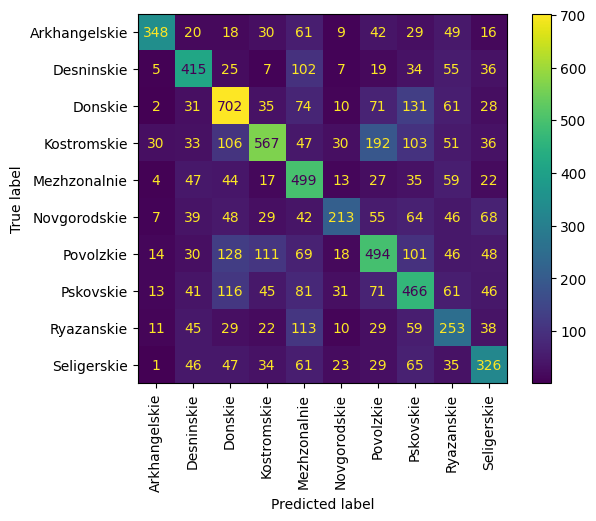

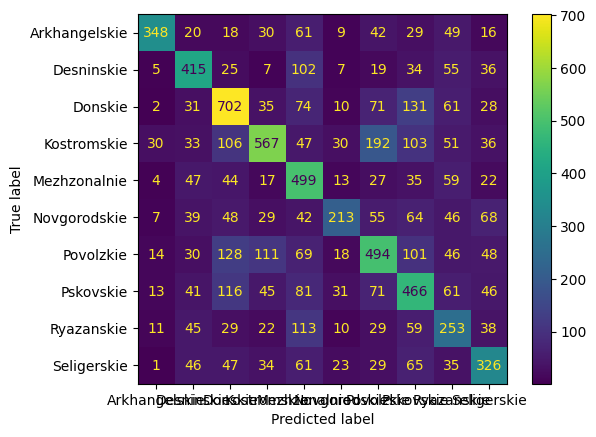

In [ ]:
model_name = 'DeepPavlov/rubert-base-cased-conversational'
lr = 3e-5
path_logs = model_name + '_' + 'logs/'
if not os.path.exists(path_logs):
  os.makedirs(path_logs)
logger = CSVLogger(path_logs, name=model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertClassifier(model_name, num_labels=len(label_encoder.classes_), lr=lr)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=preprocess_input)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False, collate_fn=preprocess_input)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, collate_fn=preprocess_input)
chk_callback = ModelCheckpoint(
      monitor='val_f1_score',
      filename='model_best',
      save_top_k=1,
      mode='max',
  )
es_callback = EarlyStopping(
      monitor='val_f1_score',
      min_delta=0.001,
      patience=5,
      verbose=False,
      mode='max'
  )
trainer = pl.Trainer(
    max_epochs=3,
    num_sanity_val_steps=1,
    logger=logger,
    callbacks=[chk_callback, es_callback]
)
trainer.fit(model, train_loader, val_loader)
res = trainer.predict(ckpt_path="best", dataloaders=test_loader)
targets = []
preds = []

for t, p in res:
  targets.extend(t)
  preds.extend(p)

print(classification_report(torch.stack(targets).cpu(), torch.stack(preds).cpu()))
disp = ConfusionMatrixDisplay.from_predictions(torch.stack(targets).cpu(), torch.stack(preds).cpu(),
                            display_labels=label_encoder.classes_, xticks_rotation='vertical')
disp.plot()


# Download the model

In [ ]:
from google.colab import files
files.download("/content/DeepPavlov/rubert-base-cased-conversational_logs/DeepPavlov/rubert-base-cased-conversational/version_0/checkpoints/model_best.ckpt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>